In [1]:
import pandas as pd
import numpy as np
import glob
import pytz
import os
from scipy import stats
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import LeaveOneGroupOut, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, RandomOverSampler
from imblearn.under_sampling import TomekLinks
from imblearn.combine import SMOTETomek
import xgboost as xgb
import optuna
import shap
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from collections import Counter

warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')
warnings.filterwarnings('ignore', category=FutureWarning)

/opt/anaconda3/envs/diss/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load in Data
EVENTS_FOLDER = '../../data/bishkek_csr/03_train_ready/event_exports' 
RESPECK_FOLDER = '../../data/bishkek_csr/03_train_ready/respeck'
NASAL_FOLDER = '../../data/bishkek_csr/03_train_ready/nasal_files'

# --- STRATEGIC FIX: Re-group the rarest classes ---
EVENT_GROUP_TO_LABEL = {
    1: ['Obstructive Apnea'],
    2: ['Hypopnea', 'Central Hypopnea', 'Obstructive Hypopnea'],
    3: ['Central Apnea', 'Mixed Apnea', 'RERA'], # Combined rare events
    4: ['Desaturation'] # Note: Relabeled from 5 to 4
}

LABEL_TO_EVENT_GROUP_NAME = {
    0: 'Normal',
    1: 'Obstructive Apnea',
    2: 'Hypopnea Events',
    3: 'Other Apnea/RERA', # New combined name
    4: 'Desaturation'
}

# --- Feature Generation Functions (Unchanged) ---
def generate_RRV(sliced_signal):
    # (Your existing generate_RRV function code here)
    sliced_signal = sliced_signal.dropna()
    if sliced_signal.empty: return np.nan
    breathingSignal = sliced_signal.values
    N = len(breathingSignal)
    if N < 2: return 0.0
    yf = np.fft.fft(breathingSignal)
    yff = 2.0 / N * np.abs(yf[:N//2])
    if len(yff) < 2: return 0.0
    dc_component_value = np.amax(yff)
    if dc_component_value == 0: return 0.0
    temp_dc_removed = np.delete(yff, np.argmax(yff))
    h1_value = np.amax(temp_dc_removed)
    rrv = 100 - (h1_value / dc_component_value) * 100
    return rrv

def extract_respeck_features(df):
    # (Your existing extract_respeck_features function code here)
    resampled_df = pd.DataFrame()
    br_resampler = df["breathingRate"].resample('30s')
    resampled_df["BR_median"], resampled_df["BR_mean"], resampled_df["BR_std"] = br_resampler.median(), br_resampler.mean(), br_resampler.std()
    resampled_df["BR_cov"] = resampled_df["BR_std"] / resampled_df["BR_mean"]
    al_resampler = df["activityLevel"].resample('30s')
    resampled_df["AL_median"], resampled_df["AL_mean"], resampled_df["AL_std"] = al_resampler.median(), al_resampler.mean(), al_resampler.std()
    resampled_df["AL_cov"] = resampled_df["AL_std"] / resampled_df["AL_mean"]
    resampled_df["RRV"] = df["breathingSignal"].resample('30s').apply(generate_RRV)
    resampled_df["RRV"] = resampled_df["RRV"].replace(0, np.nan).ffill().bfill()
    resampled_df["RRV3ANN"] = resampled_df["RRV"].rolling(window=3, center=True).mean()
    resampled_df["RRV3ANN"] = resampled_df["RRV3ANN"] * 0.65
    resampled_df['Label'] = df['Label'].resample('30s').apply(lambda x: stats.mode(x)[0] if not x.empty else 0)
    return resampled_df

# --- Data Preparation Loop ---
all_sessions_df_list = []
# (The rest of your data loading loop remains the same, it will now use the new EVENT_GROUP_TO_LABEL map)
event_files = glob.glob(os.path.join(EVENTS_FOLDER, '*_event_export.csv'))
for event_file_path in event_files:
    base_name = os.path.basename(event_file_path)
    session_id = base_name.split('_event_export.csv')[0]
    respeck_file_path = os.path.join(RESPECK_FOLDER, f'{session_id}_respeck.csv')
    if not os.path.exists(respeck_file_path): continue
    
    df_events = pd.read_csv(event_file_path, decimal=',')
    df_respeck = pd.read_csv(respeck_file_path)
    
    df_events.rename(columns={'UnixTimestamp': 'timestamp_unix'}, inplace=True)
    df_respeck.rename(columns={'alignedTimestamp': 'timestamp_unix'}, inplace=True)
    for df_ in [df_events, df_respeck]:
        df_['timestamp_unix'] = pd.to_numeric(df_['timestamp_unix'], errors='coerce')
        df_.dropna(subset=['timestamp_unix'], inplace=True)
        df_['timestamp_unix'] = df_['timestamp_unix'].astype('int64')

    df_respeck['timestamp'] = pd.to_datetime(df_respeck['timestamp_unix'], unit='ms').dt.tz_localize('UTC').dt.tz_convert('Asia/Bishkek')
    df_respeck['Label'] = 0
    df_events['Duration_ms'] = (df_events['Duration'] * 1000).astype('int64')
    df_events['end_time_unix'] = df_events['timestamp_unix'] + df_events['Duration_ms']
    
    for label_id, event_names_in_group in EVENT_GROUP_TO_LABEL.items():
        df_filtered_events = df_events[df_events['Event'].isin(event_names_in_group)]
        for _, event in df_filtered_events.iterrows():
            df_respeck.loc[df_respeck['timestamp_unix'].between(event['timestamp_unix'], event['end_time_unix']), 'Label'] = label_id
    
    df_respeck.set_index('timestamp', inplace=True)
    features_df = extract_respeck_features(df_respeck).dropna()
    features_df['SessionID'] = session_id
    all_sessions_df_list.append(features_df)

final_df = pd.concat(all_sessions_df_list).reset_index().rename(columns={'index': 'timestamp'})
print(f"\nData loading and feature generation complete. Final shape: {final_df.shape}")
print(f"Final class distribution:\n{final_df['Label'].value_counts(normalize=True)}")

# --- Prepare data for the model ---
FEATURE_COLUMNS = ['BR_median', 'BR_mean', 'BR_std', 'BR_cov', 'AL_median', 'AL_mean', 'AL_std', 'AL_cov', 'RRV', 'RRV3ANN']
X = final_df[FEATURE_COLUMNS].values
y = final_df['Label'].values
groups = final_df['SessionID'].values
X = SimpleImputer(strategy='mean').fit_transform(X)

le = LabelEncoder()
y_encoded = le.fit_transform(y)
N_OUTPUTS = len(le.classes_)
CLASS_NAMES = [LABEL_TO_EVENT_GROUP_NAME[c] for c in le.classes_]

print(f"\nTotal classes for model: {N_OUTPUTS}. Names: {CLASS_NAMES}")


Data loading and feature generation complete. Final shape: (7796, 13)
Final class distribution:
Label
0    0.908286
4    0.061570
2    0.026552
1    0.003335
3    0.000257
Name: proportion, dtype: float64

Total classes for model: 5. Names: ['Normal', 'Obstructive Apnea', 'Hypopnea Events', 'Other Apnea/RERA', 'Desaturation']


In [3]:
from sklearn.metrics import f1_score # Add this import at the top of the cell

class ImprovedXGBoostClassifier:
    def __init__(self, feature_columns, n_outputs, random_state=42):
        self.feature_columns = feature_columns
        self.n_outputs = n_outputs
        self.random_state = random_state
        self.scaler = RobustScaler()
        self.best_params = None
        self.le = None # Add a spot to store the label encoder

    def create_advanced_features(self, X_df):
        # This method is unchanged and correct.
        X_advanced = X_df.copy()
        X_advanced['BR_AL_interaction'] = X_advanced['BR_mean'] * X_advanced['AL_mean']
        X_advanced['BR_RRV_interaction'] = X_advanced['BR_mean'] * X_advanced['RRV']
        X_advanced['BR_median_mean_ratio'] = X_advanced['BR_median'] / (X_advanced['BR_mean'] + 1e-8)
        X_advanced['BR_mean_squared'] = X_advanced['BR_mean'] ** 2
        X_advanced['AL_mean_squared'] = X_advanced['AL_mean'] ** 2
        X_advanced['RRV_squared'] = X_advanced['RRV'] ** 2
        X_advanced['BR_stability'] = 1 / (1 + X_advanced['BR_cov'])
        X_advanced['activity_breathing_score'] = (X_advanced['AL_mean'] * 0.6 + X_advanced['BR_mean'] * 0.4)
        X_advanced['BR_mean_lag1'] = X_advanced['BR_mean'].shift(1)
        X_advanced['RRV_lag1'] = X_advanced['RRV'].shift(1)
        X_advanced['BR_mean_diff1'] = X_advanced['BR_mean'].diff(1)
        X_advanced['RRV_diff1'] = X_advanced['RRV'].diff(1)
        rolling_window = 3
        X_advanced['BR_rolling_std'] = X_advanced['BR_mean'].rolling(window=rolling_window, center=True).std()
        X_advanced['RRV_rolling_std'] = X_advanced['RRV'].rolling(window=rolling_window, center=True).std()
        X_advanced = X_advanced.replace([np.inf, -np.inf], np.nan).fillna(method='bfill').fillna(method='ffill')
        X_advanced = X_advanced.fillna(X_advanced.median())
        return X_advanced

    def optimize_hyperparameters(self, X_train, y_train, n_trials=50, use_weights=False):
        print("  - Optimizing hyperparameters with a custom scorer for 'Obstructive Apnea'...")

        # --- NEW: Identify the encoded label for our target class ---
        # Find the integer label that corresponds to the original class '1' (Obstructive Apnea)
        target_class_original_label = 1 
        if target_class_original_label not in self.le.classes_:
             print(f"  - WARNING: Target class {target_class_original_label} not in this fold's data. Optimizing for balanced accuracy.")
             target_class_encoded = -1 # Sentinel value
        else:
            target_class_encoded = self.le.transform([target_class_original_label])[0]
            print(f"  - 'Obstructive Apnea' (original label {target_class_original_label}) is encoded as {target_class_encoded}.")

        # --- NEW: Define the custom scorer function ---
        def obstructive_apnea_focused_scorer(y_true, y_pred):
            # If our target class isn't in the data, fall back to balanced accuracy
            if target_class_encoded == -1 or target_class_encoded not in y_true:
                return balanced_accuracy_score(y_true, y_pred)

            # Calculate F1 score for each class
            f1_scores = f1_score(y_true, y_pred, average=None, labels=np.unique(y_true), zero_division=0)
            unique_labels = np.unique(y_true)
            
            # Create a weight map
            # Give a massive weight to our target class, and tiny weights to others
            weight_map = {label: 0.05 for label in unique_labels}
            weight_map[target_class_encoded] = 1.0 # The star of the show
            
            # Normalize weights to sum to 1
            total_weight = sum(weight_map.values())
            weights = np.array([weight_map[label] / total_weight for label in unique_labels])
            
            # Calculate the final weighted F1 score
            weighted_f1 = np.sum(f1_scores * weights)
            return weighted_f1

        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=self.random_state)
        
        def objective(trial):
            params = {
                'objective': 'multi:softmax', 'num_class': self.n_outputs,
                'eval_metric': 'mlogloss', 'random_state': self.random_state,
                'n_jobs': -1, 'verbosity': 0, 'tree_method': 'hist',
                'n_estimators': trial.suggest_int('n_estimators', 200, 1000, step=100),
                'max_depth': trial.suggest_int('max_depth', 4, 10),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
                'subsample': trial.suggest_float('subsample', 0.7, 1.0),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
                'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 5.0, log=True),
                'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 5.0, log=True),
            }
            scores = []
            for tr_idx, val_idx in skf.split(X_train, y_train):
                X_tr, X_val = X_train[tr_idx], X_train[val_idx]
                y_tr, y_val = y_train[tr_idx], y_train[val_idx]
                
                fit_params = {}
                if use_weights:
                    class_weights_array = compute_class_weight('balanced', classes=np.unique(y_tr), y=y_tr)
                    weight_map = {label: weight for label, weight in zip(np.unique(y_tr), class_weights_array)}
                    fit_params['sample_weight'] = [weight_map[label] for label in y_tr]

                model = xgb.XGBClassifier(**params)
                model.fit(X_tr, y_tr, **fit_params)
                y_pred = model.predict(X_val)
                # --- Use our custom scorer ---
                scores.append(obstructive_apnea_focused_scorer(y_val, y_pred))
            return np.mean(scores)
        
        study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner())
        study.optimize(objective, n_trials=n_trials, show_progress_bar=False)
        self.best_params = study.best_params
        print(f"  - Best custom score from optimization: {study.best_value:.4f}")
        return self.best_params

    def cross_validate(self, X, y_encoded, le, groups, use_optimization=True):
        self.le = le # Store the label encoder for use in the optimizer
        
        X_df = pd.DataFrame(X, columns=self.feature_columns)
        X_engineered = self.create_advanced_features(X_df)
        print(f"  - Feature engineering applied: {X_df.shape[1]} -> {X_engineered.shape[1]} features")

        all_preds_encoded, all_true_encoded, all_importances = [], [], []
        logo = LeaveOneGroupOut()
        n_folds = logo.get_n_splits(X_engineered, y_encoded, groups=groups)
        
        print(f"Starting LONO CV with {n_folds} folds...")
        print("=" * 60)
        
        # The rest of this method uses the same robust logic as before
        for fold, (train_idx, test_idx) in enumerate(logo.split(X_engineered, y_encoded, groups)):
            test_night = np.unique(groups[test_idx])[0]
            print(f"\\n--- FOLD {fold + 1}/{n_folds} (Testing: {test_night}) ---")

            X_train, X_test = X_engineered.iloc[train_idx].values, X_engineered.iloc[test_idx].values
            y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]
            
            print(f"  - Original training distribution: {Counter(y_train)}")

            X_train_aug, y_train_aug = X_train.copy(), y_train.copy()
            unique_in_fold = np.unique(y_train_aug)
            missing_classes = np.setdiff1d(le.classes_, unique_in_fold)

            if len(missing_classes) > 0:
                print(f"  - Injecting dummy samples for missing classes: {missing_classes}")
                dummy_features = np.mean(X_train_aug, axis=0, keepdims=True)
                for cls in missing_classes:
                    X_train_aug = np.vstack([X_train_aug, dummy_features])
                    y_train_aug = np.append(y_train_aug, cls)
            
            scaler = RobustScaler()
            X_train_scaled = scaler.fit_transform(X_train_aug)
            X_test_scaled = scaler.transform(X_test)
            
            class_counts = Counter(y_train_aug)
            min_class_size = min(class_counts.values())
            
            fit_params = {}
            if min_class_size < 2:
                print(f"  - Smallest class has {min_class_size} sample(s). Falling back to sample weighting.")
                X_res, y_res = X_train_scaled, y_train_aug
                
                class_weights_array = compute_class_weight('balanced', classes=le.classes_, y=y_res)
                weight_map = {label: weight for label, weight in zip(le.classes_, class_weights_array)}
                fit_params['sample_weight'] = [weight_map[label] for label in y_res]
                
                if use_optimization and self.best_params is None:
                    self.best_params = self.optimize_hyperparameters(X_res, y_res, n_trials=30, use_weights=True)
            else:
                smote_k_neighbors = min_class_size - 1
                print(f"  - Smallest class has {min_class_size} samples. Using SMOTETomek with k_neighbors={smote_k_neighbors}.")
                resampler = SMOTETomek(
                    smote=SMOTE(k_neighbors=smote_k_neighbors, random_state=self.random_state),
                    random_state=self.random_state, n_jobs=-1
                )
                X_res, y_res = resampler.fit_resample(X_train_scaled, y_train_aug)
                print(f"  - Resampled training distribution: {Counter(y_res)}")
                
                if use_optimization and self.best_params is None:
                    self.best_params = self.optimize_hyperparameters(X_res, y_res, n_trials=30, use_weights=False)

            params = self.best_params or {}
            params.update({
                'objective': 'multi:softmax', 'num_class': self.n_outputs,
                'eval_metric': 'mlogloss', 'random_state': self.random_state,
                'n_jobs': -1, 'verbosity': 0, 'tree_method': 'hist'
            })
            
            model = xgb.XGBClassifier(**params)
            model.fit(X_res, y_res, **fit_params)

            y_pred_encoded = model.predict(X_test_scaled)
            all_preds_encoded.extend(y_pred_encoded)
            all_true_encoded.extend(y_test)
            
            print(f"  - Fold balanced accuracy: {balanced_accuracy_score(y_test, y_pred_encoded):.4f}")
            
            importance_df = pd.DataFrame({
                'feature': X_engineered.columns,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)
            all_importances.append(importance_df)

        self.model = model
        self._display_results(le, all_true_encoded, all_preds_encoded, all_importances)

    def _display_results(self, le, true_encoded, pred_encoded, importances):
        # This method is unchanged
        print("\\n" + "=" * 60 + "\\nAGGREGATED XGBOOST RESULTS\\n" + "=" * 60)
        true_labels_orig = le.inverse_transform(true_encoded)
        pred_labels_orig = le.inverse_transform(pred_encoded)
        class_names_ordered = [LABEL_TO_EVENT_GROUP_NAME[c] for c in le.classes_]
        print(f"Overall Balanced Accuracy: {balanced_accuracy_score(true_encoded, pred_encoded):.4f}\\n")
        print(classification_report(true_labels_orig, pred_labels_orig, target_names=class_names_ordered, labels=le.classes_, zero_division=0))
        cm = confusion_matrix(true_labels_orig, pred_labels_orig, labels=le.classes_)
        with np.errstate(divide='ignore', invalid='ignore'):
            cm_norm = np.nan_to_num(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])
        plt.figure(figsize=(12, 10))
        sns.heatmap(cm_norm, annot=True, fmt='.2%', cmap='Blues', xticklabels=class_names_ordered, yticklabels=class_names_ordered)
        plt.title('Aggregated Normalized Confusion Matrix (LONO)')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()
        plt.show()
        self._plot_feature_importance(importances)
        
    def _plot_feature_importance(self, importances):
        # This method is unchanged
        all_imp_df = pd.concat(importances)
        mean_imp_df = all_imp_df.groupby('feature')['importance'].mean().sort_values(ascending=False).reset_index()
        plt.figure(figsize=(10, 8))
        sns.barplot(x='importance', y='feature', data=mean_imp_df.head(15), palette='viridis')
        plt.xlabel('Mean Feature Importance (Gain)')
        plt.ylabel('Feature')
        plt.title('Top 15 Feature Importances (Averaged Across Folds)')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()

In [4]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# --- Define data for the model ---
df = final_df.copy()

FEATURE_COLUMNS = [
    'BR_median', 'BR_mean', 'BR_std', 'BR_cov', 
    'AL_median', 'AL_mean', 'AL_std', 'AL_cov',
    'RRV', 'RRV3ANN'
]
LABEL_COLUMN = 'Label' 
SESSION_ID_COLUMN = 'SessionID'
RANDOM_STATE = 42

# --- Create final X, y, and groups arrays ---
X = df[FEATURE_COLUMNS].values
y = df[LABEL_COLUMN].values
groups = df[SESSION_ID_COLUMN].values

# --- Impute any remaining NaNs ---
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# --- NEW: Initialize and fit LabelEncoder on the entire dataset's labels ---
# This makes the encoder aware of ALL possible classes (0 through 5)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
# N_OUTPUTS should now be based on the number of classes found by the encoder
N_OUTPUTS = len(le.classes_) 
# Update CLASS_NAMES to match the order found by the encoder
CLASS_NAMES = [LABEL_TO_EVENT_GROUP_NAME[c] for c in le.classes_]


print("\nData preparation complete.")
print(f"Shape of X (features): {X.shape} -> (Num_Windows, Num_Engineered_Features)")
print(f"Shape of y (labels):   {y_encoded.shape}")
print(f"Original class distribution: {Counter(y)}")
print(f"Encoded class distribution: {Counter(y_encoded)}")
print(f"Total number of classes detected: {N_OUTPUTS}")


Data preparation complete.
Shape of X (features): (7796, 10) -> (Num_Windows, Num_Engineered_Features)
Shape of y (labels):   (7796,)
Original class distribution: Counter({np.int64(0): 7081, np.int64(4): 480, np.int64(2): 207, np.int64(1): 26, np.int64(3): 2})
Encoded class distribution: Counter({np.int64(0): 7081, np.int64(4): 480, np.int64(2): 207, np.int64(1): 26, np.int64(3): 2})
Total number of classes detected: 5


In [5]:
print("\nChecking for and imputing missing values (NaNs)...")
for col in df:
    if col in df.columns:
        nan_count = df[col].isnull().sum()
        if nan_count > 0:
            print(f"  - Found {nan_count} NaNs in '{col}'. Applying forward-fill and backward-fill.")
            
            # Step 1: Forward-fill handles all NaNs except leading ones.
            df[col].ffill(inplace=True) 
            
            # Step 2: Backward-fill handles any remaining NaNs at the beginning of the file.
            df[col].bfill(inplace=True) 

# Add a final check to ensure everything is clean
final_nan_count = df[FEATURE_COLUMNS].isnull().sum().sum()
if final_nan_count > 0:
    print(f"\nWARNING: {final_nan_count} NaNs still remain in feature columns after imputation. Please investigate.")
else:
    print("\nImputation complete. No NaNs remain in feature columns.")


Checking for and imputing missing values (NaNs)...

Imputation complete. No NaNs remain in feature columns.


In [6]:
# device = torch.device(
#     "cuda" if torch.cuda.is_available()
#     else ("mps" if torch.backends.mps.is_available() else "cpu")
# )
# print(f"Using device: {device}")

  - Feature engineering applied: 10 -> 24 features
Starting LONO CV with 9 folds...
\n--- FOLD 1/9 (Testing: 04-04-2025) ---
  - Original training distribution: Counter({np.int64(0): 6042, np.int64(4): 414, np.int64(2): 201, np.int64(1): 24, np.int64(3): 2})
  - Smallest class has 2 samples. Using SMOTETomek with k_neighbors=1.


[I 2025-07-14 23:30:58,430] A new study created in memory with name: no-name-c2cf88c1-c63e-4dd9-bce5-bbebd7305594


  - Resampled training distribution: Counter({np.int64(0): 6042, np.int64(2): 6042, np.int64(4): 6042, np.int64(1): 6042, np.int64(3): 6042})
  - Optimizing hyperparameters with a custom scorer for 'Obstructive Apnea'...
  - 'Obstructive Apnea' (original label 1) is encoded as 1.


[I 2025-07-14 23:31:44,714] Trial 0 finished with value: 0.9951355527510594 and parameters: {'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.04295827412116829, 'subsample': 0.7470701033829155, 'colsample_bytree': 0.9198278118629439, 'reg_alpha': 0.08156412262201318, 'reg_lambda': 1.3658007834109729e-06}. Best is trial 0 with value: 0.9951355527510594.
[I 2025-07-14 23:32:36,442] Trial 1 finished with value: 0.9956543834188518 and parameters: {'n_estimators': 700, 'max_depth': 6, 'learning_rate': 0.15229531315937656, 'subsample': 0.7132801750499186, 'colsample_bytree': 0.9073771182357853, 'reg_alpha': 1.0444145145829094e-08, 'reg_lambda': 0.0005897425699743434}. Best is trial 1 with value: 0.9956543834188518.
[I 2025-07-14 23:34:19,580] Trial 2 finished with value: 0.9887621396083596 and parameters: {'n_estimators': 900, 'max_depth': 6, 'learning_rate': 0.010730822117713172, 'subsample': 0.7014282945686817, 'colsample_bytree': 0.8708158812243372, 'reg_alpha': 0.00113445301782448

  - Best custom score from optimization: 0.9964
  - Fold balanced accuracy: 0.2603
\n--- FOLD 2/9 (Testing: 05-04-2025) ---
  - Original training distribution: Counter({np.int64(0): 6402, np.int64(4): 348, np.int64(2): 164, np.int64(1): 21, np.int64(3): 2})
  - Smallest class has 2 samples. Using SMOTETomek with k_neighbors=1.
  - Resampled training distribution: Counter({np.int64(0): 6402, np.int64(2): 6402, np.int64(4): 6402, np.int64(1): 6402, np.int64(3): 6402})
  - Fold balanced accuracy: 0.2931
\n--- FOLD 3/9 (Testing: 08-05-2025) ---
  - Original training distribution: Counter({np.int64(0): 6486, np.int64(4): 416, np.int64(2): 175, np.int64(1): 25, np.int64(3): 2})
  - Smallest class has 2 samples. Using SMOTETomek with k_neighbors=1.
  - Resampled training distribution: Counter({np.int64(0): 6486, np.int64(2): 6486, np.int64(4): 6486, np.int64(1): 6486, np.int64(3): 6486})
  - Fold balanced accuracy: 0.2812
\n--- FOLD 4/9 (Testing: 10-05-2025) ---
  - Original training distribu

/opt/anaconda3/envs/diss/lib/python3.11/site-packages/sklearn/metrics/_classification.py:2524: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


  - Fold balanced accuracy: 0.3422
\n============================================================\nAGGREGATED XGBOOST RESULTS\n============================================================
Overall Balanced Accuracy: 0.2216\n
                   precision    recall  f1-score   support

           Normal       0.92      0.95      0.93      7081
Obstructive Apnea       0.00      0.00      0.00        26
  Hypopnea Events       0.11      0.03      0.05       207
 Other Apnea/RERA       0.00      0.00      0.00         2
     Desaturation       0.17      0.12      0.14       480

         accuracy                           0.87      7796
        macro avg       0.24      0.22      0.23      7796
     weighted avg       0.84      0.87      0.86      7796



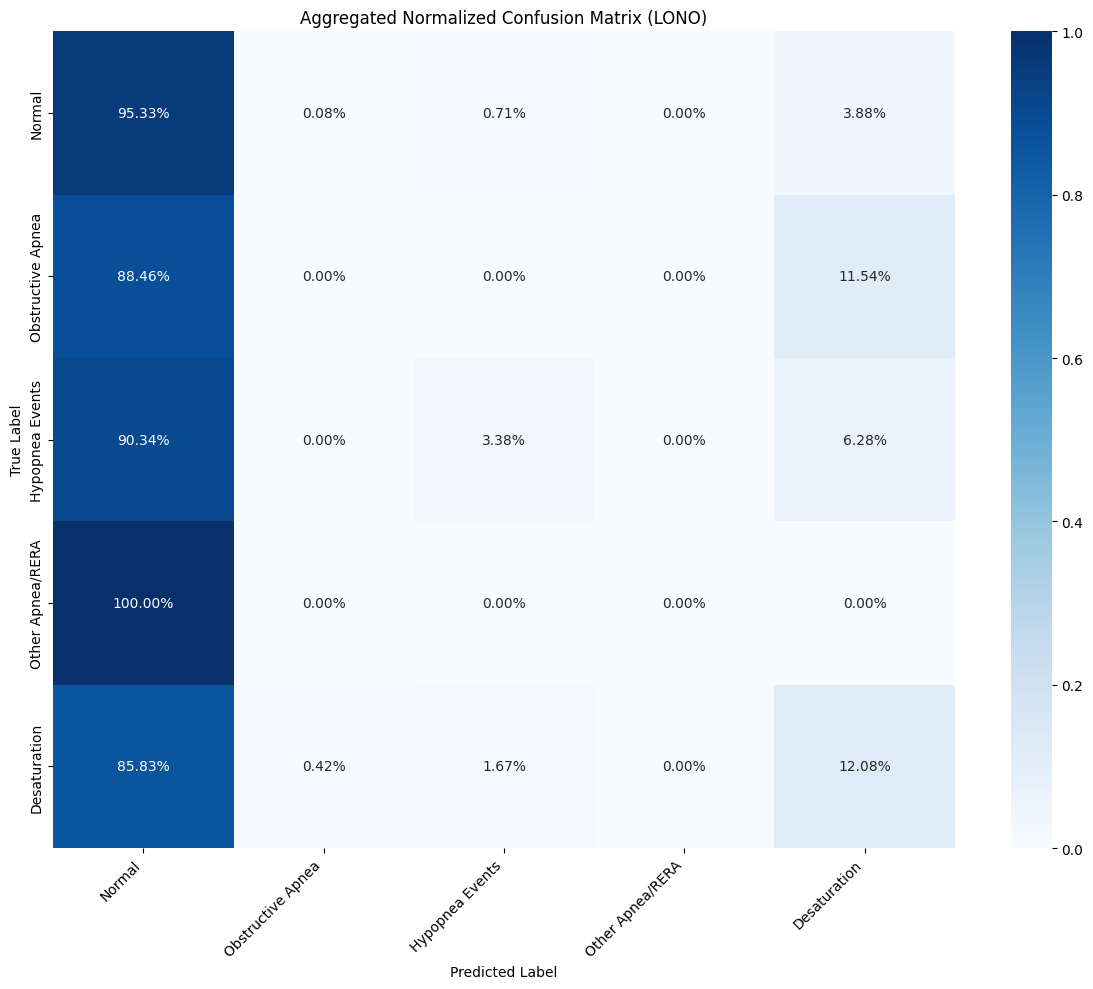

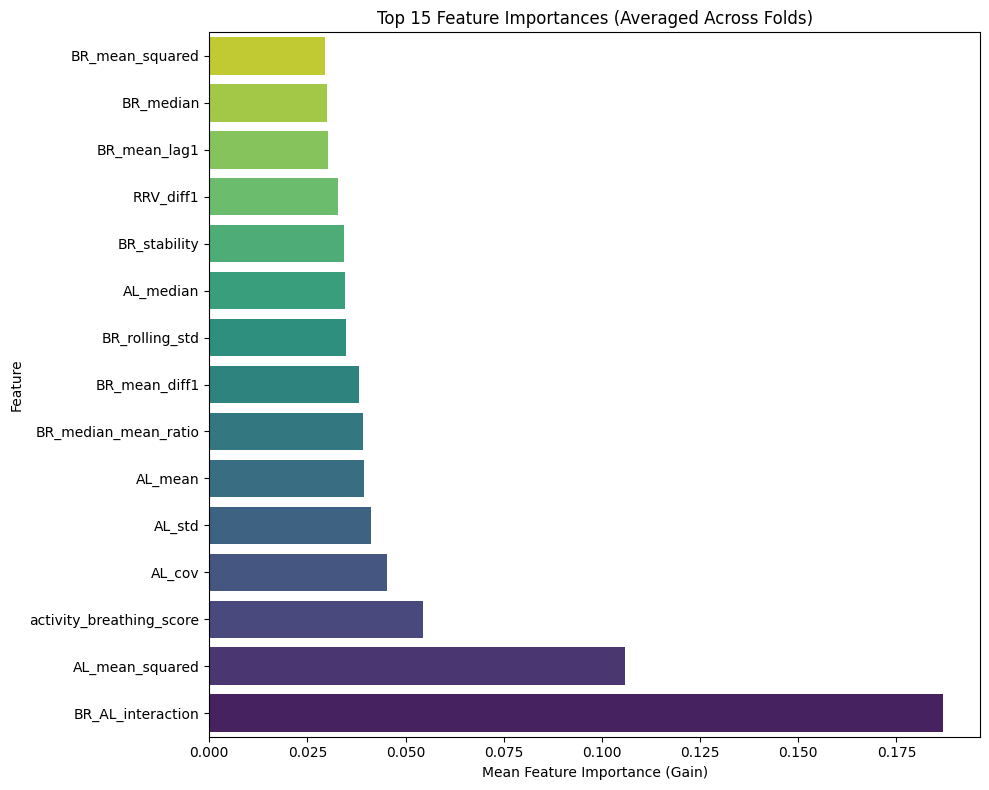

In [7]:
def run_improved_model(X, y_encoded, le, groups, feature_columns, n_outputs):
    improved_classifier = ImprovedXGBoostClassifier(
        feature_columns=feature_columns,
        n_outputs=n_outputs,
        random_state=42
    )
    
    improved_classifier.cross_validate(
        X=X, 
        y_encoded=y_encoded,
        le=le,
        groups=groups,
        use_optimization=True 
    )
    
    return improved_classifier

# Execute the pipeline
CLASS_NAMES_ORDERED = [LABEL_TO_EVENT_GROUP_NAME[c] for c in le.classes_]

improved_model = run_improved_model(
    X=X, 
    y_encoded=y_encoded, 
    le=le,
    groups=groups, 
    feature_columns=FEATURE_COLUMNS,
    n_outputs=N_OUTPUTS
)

In [8]:
# import xgboost as xgb
# from imblearn.over_sampling import SMOTE, RandomOverSampler
# from sklearn.model_selection import LeaveOneGroupOut
# from sklearn.metrics import classification_report, confusion_matrix
# from collections import Counter
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.inspection import permutation_importance

# # --- 1. Initialize lists to store results from all folds ---
# all_fold_predictions = []
# all_fold_true_labels = []
# all_fold_importances = []

# # --- 2. Setup Leave-One-Night-Out cross-validator ---
# logo = LeaveOneGroupOut()
# n_folds = logo.get_n_splits(X, y_encoded, groups=groups)
# print(f"Starting XGBoost Leave-One-Night-Out cross-validation with {n_folds} folds...")
# print("----------------------------------------------------\n")

# # --- 3. Loop through each fold ---
# for fold, (train_idx, test_idx) in enumerate(logo.split(X, y_encoded, groups)):
    
#     test_night = np.unique(groups[test_idx])[0]
#     print(f"--- FOLD {fold + 1}/{n_folds} (Testing on Night: {test_night}) ---")

#     X_train, X_test = X[train_idx], X[test_idx]
#     y_train_fold_encoded, y_test_fold = y_encoded[train_idx], y_encoded[test_idx]
    
#     # --- FINAL FIX: Robust Resampling with Dummy Sample Injection ---
#     print(f"  - Original training distribution (encoded): {Counter(y_train_fold_encoded)}")
    
#     # Find classes missing from this fold's training data
#     all_possible_classes = set(range(N_OUTPUTS))
#     present_classes = set(np.unique(y_train_fold_encoded))
#     missing_classes = all_possible_classes - present_classes
    
#     X_train_augmented = X_train
#     y_train_augmented = y_train_fold_encoded
    
#     # If any classes are missing, inject a dummy sample for each
#     if missing_classes:
#         print(f"  - Injecting dummy samples for missing classes: {missing_classes}")
#         dummy_sample_X = X_train[0:1] # Take the first sample as a template
#         for mc in missing_classes:
#             X_train_augmented = np.vstack([X_train_augmented, dummy_sample_X])
#             y_train_augmented = np.hstack([y_train_augmented, [mc]])

#     # Now, use RandomOverSampler which is safe and guaranteed to work
#     ros = RandomOverSampler(random_state=RANDOM_STATE)
#     X_res, y_res = ros.fit_resample(X_train_augmented, y_train_augmented)
    
#     print(f"  - Resampled training distribution: {Counter(y_res)}")

#     # --- Initialize and Train the XGBoost model ---
#     model = xgb.XGBClassifier(
#         objective='multi:softmax',
#         num_class=N_OUTPUTS,
#         n_estimators=500,
#         learning_rate=0.0001,
#         max_depth=4,
#         eval_metric='mlogloss',
#         random_state=RANDOM_STATE,
#         n_jobs=-1
#     )
    
#     model.fit(X_res, y_res)
#     print(f"  - Training complete.")

#     # --- Evaluate and store results ---
#     fold_preds_encoded = model.predict(X_test)
    
#     # Inverse transform predictions and true labels to their original values for reporting
#     fold_preds_original = le.inverse_transform(fold_preds_encoded)
#     fold_true_original = le.inverse_transform(y_test_fold)

#     all_fold_predictions.extend(fold_preds_original)
#     all_fold_true_labels.extend(fold_true_original)
    
#     # --- Calculate and store feature importance ---
#     result = permutation_importance(
#         model, X_test, y_test_fold, n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1, scoring='f1_weighted'
#     )
#     perm_importance = pd.DataFrame({'feature': FEATURE_COLUMNS, 'importance': result.importances_mean})
#     all_fold_importances.append(perm_importance)
    
#     print(f"  - Evaluation complete for fold {fold + 1}.\n")

# # --- FINAL AGGREGATED EVALUATION (after all folds are complete) ---
# # This part of the code remains the same as the previous correct version
# print("\n====================================================")
# print("XGBoost Leave-One-Night-Out Cross-Validation Complete.")
# print("Aggregated Results Across All Folds:")
# print("====================================================\n")

# print('Aggregated Classification Report')
# print('------------------------------')
# report_labels = le.classes_
# print(classification_report(
#     all_fold_true_labels, 
#     all_fold_predictions, 
#     labels=report_labels,
#     target_names=CLASS_NAMES,
#     zero_division=0
# ))

# print('\nAggregated Confusion Matrix')
# print('---------------------------')
# cm = confusion_matrix(all_fold_true_labels, all_fold_predictions, labels=report_labels)
# with np.errstate(divide='ignore', invalid='ignore'):
#     cm_norm = np.where(cm.sum(axis=1)[:, np.newaxis] > 0, cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 0)

# plt.figure(figsize=(12, 10))
# sns.heatmap(
#     cm_norm, annot=True, fmt='.2%', cmap='Greens',
#     xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES
# )
# plt.title('XGBoost - Aggregated Normalized Confusion Matrix (LONO)')
# plt.ylabel('True Label')
# plt.xlabel('Predicted Label')
# plt.xticks(rotation=45, ha="right")
# plt.show()

# # --- SHAP Value Analysis ---
# print("\n--- SHAP Value Analysis (from last fold) ---")
# explainer = shap.TreeExplainer(model)
# shap_values = explainer.shap_values(X_test)

# for i, class_label in enumerate(le.classes_):
#     class_name = LABEL_TO_EVENT_GROUP_NAME[class_label]
#     print(f"\nSHAP Summary Plot for: {class_name} (Encoded as {i})")
#     try:
#         shap.summary_plot(shap_values[i], X_test, feature_names=FEATURE_COLUMNS, show=False)
#         plt.title(f"SHAP Values for {class_name}")
#         plt.show()
#     except Exception as e:
#         print(f"Could not plot SHAP for class {i}: {e}")

In [9]:
# # --- AGGREGATE AND PLOT FEATURE IMPORTANCES ---
# print("\n====================================================")
# print("Feature Importance Analysis (Averaged Across All Folds)")
# print("====================================================\n")

# # --- FIX: Aggregate Data from All Folds ---
# all_importances_df = pd.concat(all_fold_importances)
# mean_importance = all_importances_df.groupby('feature')['importance'].mean()
# std_importance = all_importances_df.groupby('feature')['importance'].std()

# # --- Prepare the DataFrame for Plotting ---
# final_importance_df = pd.DataFrame({
#     'mean_importance': mean_importance,
#     'std_importance': std_importance
# }).sort_values(by='mean_importance', ascending=False)

# # --- Create the Plot ---
# fig, ax = plt.subplots(figsize=(12, 8))
# plot_data = final_importance_df.head(10) # Plot top 10 features

# ax.barh(
#     y=plot_data.index,
#     width=plot_data['mean_importance'],
#     xerr=plot_data['std_importance'],
#     align='center',
#     ecolor='black',
#     capsize=5
# )

# ax.invert_yaxis() 
# ax.set_xlabel('Mean Permutation Importance (Weighted F1)')
# ax.set_ylabel('Feature')
# ax.set_title('Top 10 Feature Importances (Averaged Across LONO Folds)')
# ax.grid(axis='x', linestyle='--', alpha=0.7)
# plt.tight_layout()
# plt.show()